In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [ ]:
# Load dataset mnist
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

In [ ]:
print(ds_info)

# 1. Training: 60000 | Testing: 10000
# 2. Shape: (28, 28, 1)
# 3. Max: 255

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [ ]:
def prepare_data(mnist):

    # Flatten image
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # Cast ints to floats
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # Distribute image around 0
    mnist = mnist.map(lambda img, target: ((img / 128) - 1., target))

    # One-hotify labels
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # Load dataset into memory
    mnist = mnist.cache()

    # Shuffle loaded dataset
    mnist = mnist.shuffle(1000)

    # Split into batches by size
    mnist = mnist.batch(32)

    # Preload later batches of dataset
    mnist = mnist.prefetch(20)

    return mnist

train_dataset = train_ds.apply(prepare_data)
test_dataset = test_ds.apply(prepare_data)

In [ ]:
class MyModel(tf.keras.Model):

    def __init__(self):

        super(MyModel, self).__init__()

        # Initialize layers
        self.fst_h_layer = tf.keras.layers.Dense(units=128, activation=tf.nn.sigmoid)
        self.sec_h_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.sigmoid)
        self.out = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)

    # Forward step
    @tf.function
    def call(self, input):
        x = self.fst_h_layer(input)
        x = self.sec_h_layer(x)
        x = self.out(x)
        return x

In [ ]:
def test(model, test_data, loss_function):
  # test over complete test data

    global loss_test_arr
    global acc_test_arr

    test_accuracy = []
    test_loss = []

    for (input, target) in test_data:

        # Run image through model
        prediction = model(input)

        # Determine loss and accuracy of image
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss.append(sample_test_loss.numpy())
        test_accuracy.append(np.mean(sample_test_accuracy))

    # Add loss and accuracy of samples of batch to global arrays
    loss_test_arr.append(tf.reduce_mean(test_loss))
    acc_test_arr.append(tf.reduce_mean(test_accuracy))

In [ ]:
def training(epochs, model, training_data, test_data, loss_func, opt_func):
    loss_per_epoch = []

    global loss_train_arr

    global loss_test_arr
    global acc_test_arr


    for i in range(epochs):

        print(f"Executing epoch {str(i+1)}, starting with accuracy {acc_test_arr[-1]}")

        # Iterate through batches
        for image, label in training_data:

            # Use Gradient-Tape
            with tf.GradientTape() as tape:

                # Run batches through model and determine loss
                prediction = model(image)
                loss = loss_func(label, prediction)

            # Fit model
            loss_per_epoch.append(loss)
            gradients = tape.gradient(loss_per_epoch, model.trainable_variables)
            opt_func.apply_gradients(zip(gradients, model.trainable_variables))

        # Determine loss and accuracy for training
        test(model, test_data, loss_func)

        # Add loss of training to global variables
        loss_train_arr.append(tf.reduce_mean(loss_per_epoch))


In [ ]:
# Hyperparameters
learning_rate = 0.1
epochs = 10
momentum = 0.5

# Necessary objects
loss_cce = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate, momentum)
model_func = MyModel()

# Arrays given to training and testing function
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []

# First test to determine accuracy
test(model_func, test_dataset, loss_cce)

In [ ]:
tf.keras.backend.clear_session()

model = training(epochs=epochs, model=model_func, training_data=train_dataset, test_data=test_dataset, loss_func=loss_cce, opt_func=opt)
print(f"Ended epoch 10, ending with {acc_test_arr[-1]}")

Executing epoch 1, starting with accuracy 0.10123801916932908


Executing epoch 2, starting with accuracy 0.9278154952076677
Executing epoch 3, starting with accuracy 0.9477835463258786
Executing epoch 4, starting with accuracy 0.9596645367412141
Executing epoch 5, starting with accuracy 0.9607627795527156
Executing epoch 6, starting with accuracy 0.9603634185303515
Executing epoch 7, starting with accuracy 0.9699480830670927
Executing epoch 8, starting with accuracy 0.9713458466453674
Executing epoch 9, starting with accuracy 0.9715455271565495
Executing epoch 10, starting with accuracy 0.9737420127795527
Ended epoch 10, ending with 0.9719448881789138


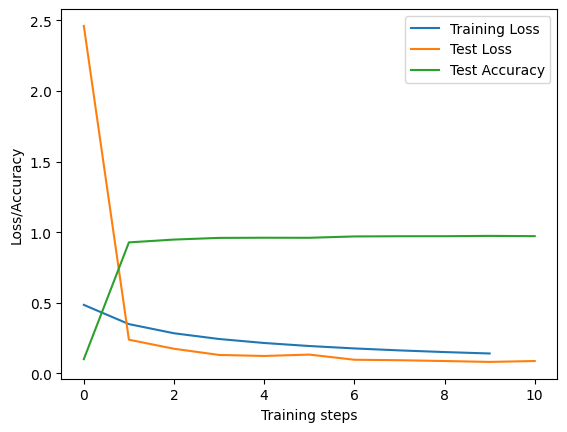

In [ ]:
plt.figure()
line1 , = plt.plot(loss_train_arr,)
line2 , = plt.plot(loss_test_arr)
line3 , = plt.plot(acc_test_arr)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1, line2, line3), ("Training Loss", "Test Loss", "Test Accuracy"))
plt.show()

Original:
- Learning Rate: 0.1
- Layers: [256, 256, 10]
- Epochs: 10
- Batch size: 32
- Momentum: 0.0


Version 1:
- Learning Rate: 0.01
- Layers: [256, 10]
- Epochs: 10
- Batch size: 64
- Momentum: 0.5

\> Continuous increase in accuracy. No fluctuations in accuracy. Loss in testing starts high pre training, and in the first epoch lowers dramatically.

Version 2:
- Learning Rate: 0.01
- Layers: [128, 64, 10]
- Epochs: 10
- Batch size: 32
- Momentum: 0.5

\> Earlier fluctuations in accuracy than other versions.

Version 3:
- Learning Rate: 0.1
- Layers: [128, 10]
- Epochs: 10
- Batch size: 32
- Momentum: 0.5

\>  Close to 100%. Straight increase in accuracy with small fluctuations only in high accuracy with higher and higher lows as well as highs.

Version 4:
- Learning Rate: 0.01
- Layers: [256, 256, 128, 10]
- Epochs: 10
- Batch size: 64
- Momentum: 0.5

\> The accuracy rose slower than in other versions but did not reach as higher as other versions. Loss both decreased in both training and testing.
Interestingly, the calculations were faster despite higher more layers and higher number of perceptrons, likely because of batch size.